<a href="https://colab.research.google.com/github/LizaAmatya/FakeNewsDetection/blob/main/training_binary_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -r https://raw.githubusercontent.com/LizaAmatya/FakeNewsDetection/main/requirements.txt?token=GHSAT0AAAAAACJI6OXTGQWNXIXC4OWHHULOZLOBFXQ

In [ ]:
import os
import pandas as pd
import tensorflow as tf
# import tensorflow_text
from transformers import BertTokenizer, TFBertForSequenceClassification, DistilBertTokenizer, TFDistilBertForSequenceClassification
import numpy as np
import csv
from sklearn.model_selection import train_test_split


In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.run_functions_eagerly(False)
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2", "/gpu:3"])

Running on TPU  ['10.4.95.234:8470']


In [ ]:
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = "/content/sample_data"

In [ ]:
column_labels = ['title','text','subject','date']

In [29]:
fake_data = os.path.join(BASE_DIR, 'dataset2/fake.tsv')
true_data = os.path.join(BASE_DIR, 'dataset2/true.tsv')

fake_data = pd.read_csv(fake_data, sep="\t", header=None, names=column_labels)
true_data = pd.read_csv(true_data, sep="\t", header=None, names=column_labels)

fake_data['label'] = "false"
true_data['label'] = "true"

combined_dataset = np.concatenate((fake_data, true_data), axis=0)
# Shuffle the combined dataset
np.random.shuffle(combined_dataset)

print(combined_dataset)
train, val = train_test_split(combined_dataset, test_size=0.3, random_state=42)
train = pd.DataFrame(train, columns=['title', 'text', 'subject', 'date', 'label'])
val = pd.DataFrame(val, columns=['title', 'text', 'subject', 'date', 'label'])

label_mapping = {'false':0, 'true':1}
train['label_encoded'] = train['label'].map(label_mapping)
val['label_encoded'] = val['label'].map(label_mapping)


In [ ]:
num_of_classes=2

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
# Tokenize the title, text and subject

train_encoded_statement_data = tokenizer(
    train['text'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
train['metadata'] = train['title'].astype(str) + ' ' + train['subject'].astype(str)

train_encoded_metadata = tokenizer(
    train['metadata'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

In [12]:
val_encoded_statement_data = tokenizer(
    val['text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
val['metadata'] = val['title'].astype(str) + ' ' + val['subject'].astype(str)

val_encoded_metadata = tokenizer(
    val['metadata'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

In [31]:
# Create TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encoded_statement_data['input_ids'],
        'attention_mask': train_encoded_statement_data['attention_mask'],
        'input_ids_metadata': train_encoded_metadata['input_ids'],
        'attention_mask_metadata': train_encoded_metadata['attention_mask']
    },
    train['label_encoded'] ))

In [32]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encoded_statement_data['input_ids'],
        'attention_mask': val_encoded_statement_data['attention_mask'],
        'input_ids_metadata': val_encoded_metadata['input_ids'],
        'attention_mask_metadata': val_encoded_metadata['attention_mask']

    },
    val['label_encoded'] ))

In [ ]:
# Limiting the dataset
# limit = 50
# limited_train_dataset = train_dataset.take(limit)

In [15]:
num_epochs = 10
batch_size = 32

In [16]:
# Creating model with BERT
from tensorflow.keras.layers import Input
max_length = 128
def create_bert_model():
    model_name = 'bert-base-uncased'
    model = TFBertForSequenceClassification.from_pretrained(model_name)

    # Define input layers
    input_ids_statement = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask_statement = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    input_ids_metadata = Input(shape=(max_length,), dtype=tf.int32, name='input_ids_metadata')
    attention_mask_metadata = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_metadata')

    bert_output_statement = model([input_ids_statement, attention_mask_statement])
    bert_output_metadata = model([input_ids_metadata, attention_mask_metadata])

    # Extract logits for the positive class from each branch
    positive_class_statement_logits = bert_output_statement.logits[:, 1]
    positive_class_metadata_logits = bert_output_metadata.logits[:, 1]

    positive_class_statement_logits = tf.expand_dims(positive_class_statement_logits, axis=-1)
    positive_class_metadata_logits = tf.expand_dims(positive_class_metadata_logits, axis=-1)

    # Add dense layers for classification on each branch
    dense_layer_statement = tf.keras.layers.Dense(256, activation='relu')(positive_class_statement_logits)
    dense_layer_metadata = tf.keras.layers.Dense(256, activation='relu')(bert_output_metadata.logits)

    # Merge the outputs using Concatenate or other merging strategies
    merged_output = tf.keras.layers.Concatenate(axis=-1)([dense_layer_statement, dense_layer_metadata])

    # Add additional dense layers for classification
    final_dense_layer = tf.keras.layers.Dense(128, activation='relu')(merged_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(final_dense_layer)

    custom_model = tf.keras.Model(inputs=[input_ids_statement, attention_mask_statement, input_ids_metadata, attention_mask_metadata],
                                  outputs=output)
    custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])

    return custom_model

In [17]:
# Create a new model with the BERT base and the custom output layer

def create_model():
  model = TFBertForSequenceClassification.from_pretrained(model_name)
  input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

  # Adding a dense layer for the output
  bert_output = model([input_ids, attention_mask])
  cls_token = bert_output.logits
  positive_class_logits = cls_token[:, 1]  # Extract logits for the positive class
  positive_class_logits = tf.expand_dims(positive_class_logits, axis=-1)
  dense_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='dense_output')
  output = dense_layer(positive_class_logits)

  # dense layer with 1 unit and use an appropriate activation function (such as sigmoid) in a binary classification scenario,
  # it means that the output of the model will be a single scalar value between 0 and 1. This scalar can be interpreted as the predicted probability of belonging to the positive class.
  # Making logits and labels dim same
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
  custom_model = tf.keras.Model(inputs=model.input, outputs=output)
  custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])

  return custom_model

In [18]:
# strategy = tf.distribute.MirroredStrategy()
with tpu_strategy.scope():
    custom_model = create_bert_model()

custom_model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]',         
 fication)                      logits=(None, 2),                 'input_ids_metadata[0][0]',     
                                 hidden_states=None               'attention_mask_metadata[0][

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(custom_model, to_file='binary_custom_model.png', show_shapes=True, show_layer_names=True)

# If you want to save separate images for train, validation, and test datasets
plot_model(custom_model, to_file='train_model_binary.png', show_shapes=True, show_layer_names=True, rankdir='LR')
# plot_model(custom_model, to_file='validation_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')
# plot_model(custom_model, to_file='test_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [20]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(BASE_DIR, 'model_checkpoint'),  # Specify the path to save the checkpoint
    save_best_only=True,  # Save only the best model based on the validation loss
    monitor='val_loss',  # Monitor the validation loss
    mode='min',  # Mode can be 'min' or 'max' depending on the monitored metric
    verbose=1  # Show progress while saving
)

In [21]:
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback

train_steps_per_epoch = len(train_dataset)
tqdm_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: tqdm(total=train_steps_per_epoch, position=0, desc="Epoch", unit="batch"),
    on_epoch_end=lambda epoch, logs: tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Loss: {logs["loss"]}, Accuracy: {logs["sparse_categorical_accuracy"]}, Val Loss: {logs["val_loss"]}, Val Accuracy: {logs["val_sparse_categorical_accuracy"]}'),
    on_batch_end=lambda batch, logs: tqdm.update(1)
)

class ProgressBarCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs += 1
        self.pbar.update(1)
        self.pbar.set_postfix(logs, refresh=True)

    def on_train_begin(self, logs=None):
        self.epochs = 0
        self.pbar = tqdm(total=self.params['epochs'], unit='epoch', position=0)

    def on_train_end(self, logs=None):
        self.pbar.close()

In [33]:
print('Start training')
progress_bar_callback = ProgressBarCallback()
history = custom_model.fit(
    train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE),
    epochs=num_epochs,
    validation_data=val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
    verbose=1,
    callbacks=[progress_bar_callback, checkpoint_callback]
)

  0%|          | 0/10 [06:41<?, ?epoch/s]


Start training


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10
  6/140 [>.............................] - ETA: 13s - loss: 0.6740 - accuracy: 0.4844

140/140 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9616

 10%|█         | 1/10 [02:00<18:04, 120.50s/epoch, loss=0.107, accuracy=0.962, val_loss=3.2, val_accuracy=0.497]

140/140 [==============================] - 119s 243ms/step - loss: 0.1075 - accuracy: 0.9616 - val_loss: 3.2043 - val_accuracy: 0.4969
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9996

 20%|██        | 2/10 [02:18<08:03, 60.47s/epoch, loss=0.00359, accuracy=1, val_loss=3.95, val_accuracy=0.497] 

140/140 [==============================] - 18s 127ms/step - loss: 0.0036 - accuracy: 0.9996 - val_loss: 3.9536 - val_accuracy: 0.4969
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9996

 30%|███       | 3/10 [02:38<04:51, 41.62s/epoch, loss=0.00248, accuracy=1, val_loss=4.3, val_accuracy=0.496] 

140/140 [==============================] - 19s 133ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 4.2970 - val_accuracy: 0.4964
Epoch 4/10
140/140 [==============================] - ETA: 0s - loss: 7.8863e-04 - accuracy: 0.9996

 40%|████      | 4/10 [03:04<03:33, 35.60s/epoch, loss=0.000789, accuracy=1, val_loss=4.7, val_accuracy=0.497]

140/140 [==============================] - 24s 174ms/step - loss: 7.8863e-04 - accuracy: 0.9996 - val_loss: 4.7008 - val_accuracy: 0.4969
Epoch 5/10
140/140 [==============================] - ETA: 0s - loss: 5.3003e-04 - accuracy: 0.9996

 50%|█████     | 5/10 [03:23<02:27, 29.56s/epoch, loss=0.00053, accuracy=1, val_loss=4.87, val_accuracy=0.496]

140/140 [==============================] - 18s 128ms/step - loss: 5.3003e-04 - accuracy: 0.9996 - val_loss: 4.8722 - val_accuracy: 0.4964
Epoch 6/10
140/140 [==============================] - ETA: 0s - loss: 3.8914e-04 - accuracy: 0.9998

 60%|██████    | 6/10 [03:43<01:44, 26.22s/epoch, loss=0.000389, accuracy=1, val_loss=5.09, val_accuracy=0.497]

140/140 [==============================] - 19s 136ms/step - loss: 3.8914e-04 - accuracy: 0.9998 - val_loss: 5.0863 - val_accuracy: 0.4969
Epoch 7/10
140/140 [==============================] - ETA: 0s - loss: 5.9355e-04 - accuracy: 0.9998

 70%|███████   | 7/10 [04:01<01:10, 23.60s/epoch, loss=0.000594, accuracy=1, val_loss=5.05, val_accuracy=0.496]

140/140 [==============================] - 18s 125ms/step - loss: 5.9355e-04 - accuracy: 0.9998 - val_loss: 5.0460 - val_accuracy: 0.4964
Epoch 8/10
140/140 [==============================] - ETA: 0s - loss: 5.1661e-04 - accuracy: 0.9996

 80%|████████  | 8/10 [04:19<00:43, 21.89s/epoch, loss=0.000517, accuracy=1, val_loss=5.26, val_accuracy=0.496]

140/140 [==============================] - 18s 126ms/step - loss: 5.1661e-04 - accuracy: 0.9996 - val_loss: 5.2554 - val_accuracy: 0.4964
Epoch 9/10
140/140 [==============================] - ETA: 0s - loss: 7.6037e-04 - accuracy: 0.9998

 90%|█████████ | 9/10 [04:37<00:20, 20.78s/epoch, loss=0.00076, accuracy=1, val_loss=5.23, val_accuracy=0.497] 

140/140 [==============================] - 17s 125ms/step - loss: 7.6037e-04 - accuracy: 0.9998 - val_loss: 5.2295 - val_accuracy: 0.4969
Epoch 10/10
140/140 [==============================] - ETA: 0s - loss: 4.4364e-04 - accuracy: 0.9996

100%|██████████| 10/10 [04:56<00:00, 20.21s/epoch, loss=0.000444, accuracy=1, val_loss=5.32, val_accuracy=0.497]

140/140 [==============================] - 18s 131ms/step - loss: 4.4364e-04 - accuracy: 0.9996 - val_loss: 5.3190 - val_accuracy: 0.4969


100%|██████████| 10/10 [04:56<00:00, 29.68s/epoch, loss=0.000444, accuracy=1, val_loss=5.32, val_accuracy=0.497]


In [38]:
test_path = os.path.join(BASE_DIR, 'dataset/test.tsv')
column_labels = ['row', 'json_ids', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'lies_counts', 'context', 'justification']
test = pd.read_csv(test_path, sep="\t", header=None, names=column_labels)

test['label_encoded'] = np.where(np.isin(test['label'], ['mostly-true', 'true']), 1, 0)

# Tokenize and preprocess the test data
test_encoded_statement_data = tokenizer(
    test['statement'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
test['label_encoded'] = train['label'].map(label_mapping)
test['metadata'] = test['subject'].astype(str) + ' ' + test['speaker'].astype(str) + ' ' + test['job_title'].astype(str) + ' ' + test['state'].astype(str) + ' ' + test['affiliation'].astype(str) + ' ' + test['context'].astype(str)

test_encoded_metadata = tokenizer(
    test['metadata'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# Create TensorFlow dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encoded_statement_data['input_ids'],
        'attention_mask': test_encoded_statement_data['attention_mask'],
        'input_ids_metadata': test_encoded_metadata['input_ids'],
        'attention_mask_metadata': test_encoded_metadata['attention_mask']
    },
    test['label_encoded']
))

test_steps = len(test_dataset)
# progbar = Progbar(test_steps)

# Evaluate the model on the test dataset
with tpu_strategy.scope():
  results = custom_model.evaluate(test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE))

# Display the results and update the progress bar
for metric_name, result in zip(custom_model.metrics_names, results):
    print(f'{metric_name}: {result}')

    # Update progress bar
    # progbar.update(1)
# Print the evaluation results (including accuracy)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

40/40 [==============================] - 10s 220ms/step - loss: 3.4350 - accuracy: 0.5087
loss: 3.434962749481201
accuracy: 0.5086750984191895
Test Loss: 3.434962749481201
Test Accuracy: 0.5086750984191895


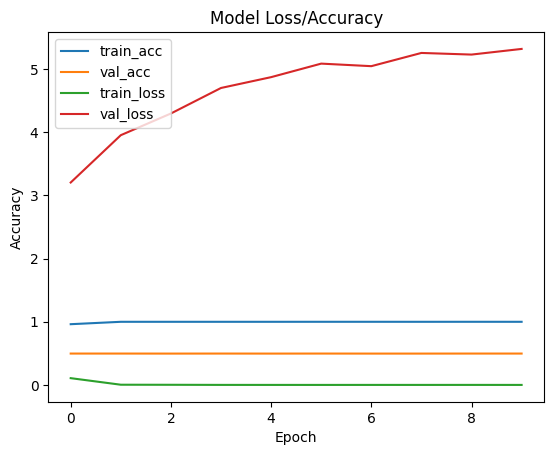

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss/Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper left')
plt.show()
